In [10]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

In [11]:
# ===== TP8 — Préparation des données (RGB) =====
from pathlib import Path
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch

# 1) Chemin des données RGB organisées par classes 
SOURCE_DIR = Path(r'..\tp8\archive\AMHCD_64\AMHCD_64') 
assert SOURCE_DIR.exists(), f"Introuvable : {SOURCE_DIR}"

# 2) Transforms 
base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),          
])

# 3) Dataset complet pour préparer le split
full = datasets.ImageFolder(SOURCE_DIR, transform=base_transform)
targets = np.array(full.targets)    
class_names = full.classes
print("Classes:", class_names, "| Total images:", len(full))

# 4) Split STRATIFIÉ 80/10/10
idx = np.arange(len(full))

# 80% train, 20% temp
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, temp_idx in sss1.split(idx, targets):
    pass

# temp -> 10% val, 10% test
temp_targets = targets[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_rel, test_rel in sss2.split(temp_idx, temp_targets):
    val_idx  = temp_idx[val_rel]
    test_idx = temp_idx[test_rel]

print(f"Split -> train:{len(train_idx)}  val:{len(val_idx)}  test:{len(test_idx)}")

# 5)  Calcul mean/std sur le TRAIN 
loader_stats = DataLoader(Subset(full, train_idx), batch_size=128, shuffle=False, num_workers=2)
channel_sum  = torch.zeros(3)
channel_sq   = torch.zeros(3)
num_pixels   = 0

for x, _ in loader_stats:
    # x: [B, C=3, H, W]
    b, c, h, w = x.shape
    num_pixels  += b * h * w
    channel_sum += x.sum(dim=(0, 2, 3))
    channel_sq  += (x**2).sum(dim=(0, 2, 3))

mean = (channel_sum / num_pixels)
var  = (channel_sq / num_pixels) - mean**2
std  = torch.sqrt(var.clamp_min(1e-8))
mean, std = mean.tolist(), std.tolist()
print("Train mean:", mean, "| std:", std)

# 6) Transformation final avec normalisation
train_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tf = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 7) Redéfinir des datasets avec les bons transforms
train_base = datasets.ImageFolder(SOURCE_DIR, transform=train_tf)
val_base   = datasets.ImageFolder(SOURCE_DIR, transform=eval_tf)
test_base  = datasets.ImageFolder(SOURCE_DIR, transform=eval_tf)

train_set = Subset(train_base, train_idx)
val_set   = Subset(val_base,   val_idx)
test_set  = Subset(test_base,  test_idx)

# 8) DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_set,  batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

print("Dataloaders OK.")


Classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh', 'yaj', 'yak', 'yakw', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu'] | Total images: 25740
Split -> train:20592  val:2574  test:2574
Train mean: [0.9270791411399841, 0.9265097975730896, 0.9466421008110046] | std: [0.1367274671792984, 0.14038170874118805, 0.10006013512611389]
Dataloaders OK.


In [12]:
# Définition du modèle LeNet-5 (TP8 - RGB)
class LeNet5(nn.Module):
    def __init__(self, in_channels=3, num_classes=33, use_dropout=False, p_drop=0.2):
        super(LeNet5, self).__init__()
        # Convolutions + pooling (identiques à LeNet-5, mais entrée en 3 canaux)
        self.conv1 = nn.Conv2d(in_channels, 6, kernel_size=5)       # 3 -> 6
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)                # 6 -> 16
        self.pool2 = nn.AvgPool2d(2, stride=2)

        # Taille à plat pour entrée 32x32 (sans padding) :
        # 32 -> (conv5) 28 -> (pool2) 14 -> (conv5) 10 -> (pool2) 5
        # donc 16 * 5 * 5 = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Dropout optionnel (désactivé par défaut)
        self.dropout = nn.Dropout(p_drop) if use_dropout else nn.Identity()

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 6, 28, 28]
        x = self.pool1(x)           # [B, 6, 14, 14]
        x = F.relu(self.conv2(x))   # [B,16, 10, 10]
        x = self.pool2(x)           # [B,16,  5,  5]
        x = x.view(x.size(0), -1)   # [B, 16*5*5]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [13]:
# ===== TP8 — Fonctions d'entraînement et d'évaluation (RGB) =====
from typing import Tuple, Optional
import torch

def train_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    device: torch.device,
    use_amp: bool = True,
    grad_clip: Optional[float] = None,
) -> Tuple[float, float]:
    """
    Entraîne le modèle pour 1 epoch.
    Retourne (loss_moyenne, accuracy).
    """
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    loss_sum, correct, n_total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()

        if grad_clip is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        scaler.step(optimizer)
        scaler.update()

        # stats (pondérées par la taille réelle du batch)
        bs = y.size(0)
        loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n_total += bs

    return loss_sum / n_total, correct / n_total


@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    criterion: torch.nn.Module,
    device: torch.device,
    return_preds: bool = False,
):
    """
    Évalue le modèle.
    Retourne (loss_moyenne, accuracy) et, si return_preds=True, (preds, labels).
    """
    model.eval()
    loss_sum, correct, n_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        bs = y.size(0)
        loss_sum += loss.item() * bs
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n_total += bs

        if return_preds:
            all_preds.extend(preds.detach().cpu().tolist())
            all_labels.extend(y.detach().cpu().tolist())

    if return_preds:
        return (loss_sum / n_total, correct / n_total, all_preds, all_labels)
    else:
        return loss_sum / n_total, correct / n_total


In [14]:
# ===== TP8 — Boucle d'apprentissage (RGB) =====
from pathlib import Path
import torch, os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nb_classes déduit des données si dispo, sinon 33
num_classes = len(class_names) if "class_names" in globals() else 33

model = LeNet5(in_channels=3, num_classes=num_classes, use_dropout=False).to(device)

# Optimiseur / Critère
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)  # tu peux essayer lr=0.002 aussi
criterion = nn.CrossEntropyLoss()

# (Optionnel) Scheduler : baisse le LR à mi-parcours
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

# Suivi & checkpoint
epochs = 20
RESULTS_DIR = Path("./results_tp8")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
best_ckpt_path = RESULTS_DIR / "lenet5_rgb_best.pt"

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_acc = -1.0
use_amp = (device.type == "cuda")
patience, bad_epochs = 5, 0  # early stopping (optionnel)

for epoch in range(1, epochs + 1):
    # Entraînement (1 epoch)
    tr_loss, tr_acc = train_epoch(
        model, train_loader, optimizer, criterion, device,
        use_amp=use_amp, grad_clip=None
    )

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)[:2]

    # Historique
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    # Scheduler (StepLR)
    scheduler.step()

    # Affichage
    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.2%} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.2%} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e}")

    # Sauvegarde du meilleur modèle (sur val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "state_dict": model.state_dict(),
            "val_acc": best_val_acc,
            "epoch": epoch,
            "classes": class_names if "class_names" in globals() else None
        }, best_ckpt_path)
        bad_epochs = 0
    else:
        bad_epochs += 1

    # Early stopping (optionnel)
    if bad_epochs >= patience:
        print(f"  Early stopping: pas d'amélioration de val_acc depuis {patience} epochs.")
        break

print(f"\nMeilleure val_acc: {best_val_acc:.2%} (checkpoint: {best_ckpt_path.name})")

# Recharger le meilleur état (utile avant l'évaluation finale sur test)
best = torch.load(best_ckpt_path, map_location="cpu")
model.load_state_dict(best["state_dict"])
model.to(device)


C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\1461812044.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\1461812044.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[Epoch 01/20] train_loss=0.7381 acc=79.35% | val_loss=0.2470 acc=91.65% | lr=1.00e-03
[Epoch 02/20] train_loss=0.1761 acc=94.87% | val_loss=0.1712 acc=94.72% | lr=1.00e-03
[Epoch 03/20] train_loss=0.1122 acc=96.58% | val_loss=0.1215 acc=96.19% | lr=1.00e-03
[Epoch 04/20] train_loss=0.0802 acc=97.47% | val_loss=0.1219 acc=96.39% | lr=1.00e-03
[Epoch 05/20] train_loss=0.0613 acc=98.01% | val_loss=0.1083 acc=96.81% | lr=1.00e-03
[Epoch 06/20] train_loss=0.0503 acc=98.39% | val_loss=0.0947 acc=97.32% | lr=1.00e-03
[Epoch 07/20] train_loss=0.0442 acc=98.70% | val_loss=0.0923 acc=97.51% | lr=1.00e-03
[Epoch 08/20] train_loss=0.0348 acc=98.80% | val_loss=0.0762 acc=97.94% | lr=5.00e-04
[Epoch 09/20] train_loss=0.0128 acc=99.63% | val_loss=0.0582 acc=98.60% | lr=5.00e-04
[Epoch 10/20] train_loss=0.0090 acc=99.73% | val_loss=0.0951 acc=97.86% | lr=5.00e-04
[Epoch 11/20] train_loss=0.0067 acc=99.82% | val_loss=0.0715 acc=98.48% | lr=5.00e-04
[Epoch 12/20] train_loss=0.0074 acc=99.78% | val_loss=

C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\1904659898.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load(best_ckpt_path, map_location="cpu")


LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=33, bias=True)
  (dropout): Identity()
)

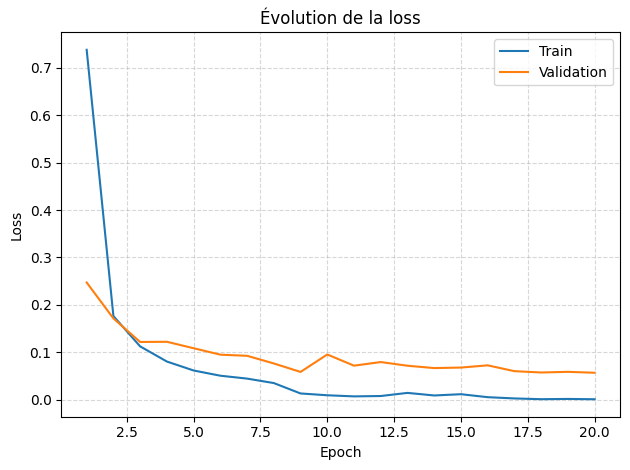

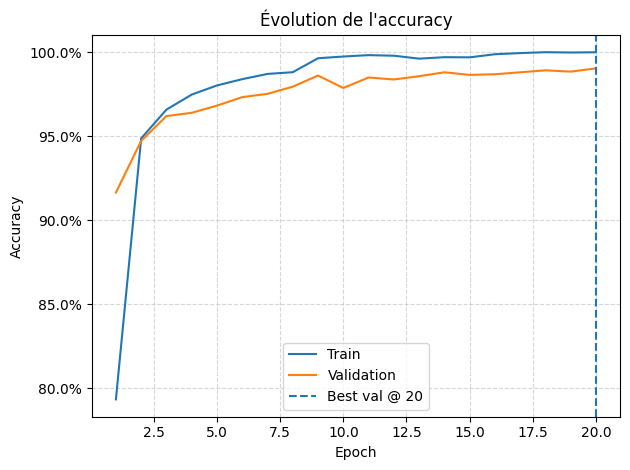

Courbes enregistrées dans: C:\Users\ADMIN_SB\Desktop\master IAA\S2\Deep Learning\TP8\results_tp8


In [15]:
# ===== TP8 — Courbes loss & accuracy =====
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.ticker import PercentFormatter

RESULTS_DIR = Path("./results_tp8")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Séquence d'epochs alignée sur les listes mesurées
epochs_tr = np.arange(1, len(train_losses) + 1)
epochs_va = np.arange(1, len(val_losses)   + 1)

# ---- Courbe Loss ----
plt.figure()
plt.plot(epochs_tr, train_losses, label="Train")
plt.plot(epochs_va, val_losses,   label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Évolution de la loss")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "curve_loss.png", dpi=150)
plt.show()

# ---- Courbe Accuracy ----
plt.figure()
plt.plot(epochs_tr, train_accs, label="Train")
plt.plot(epochs_va, val_accs,   label="Validation")

# Marquer l'epoch de meilleure val_acc (si dispo)
if len(val_accs) > 0:
    best_epoch = int(np.argmax(val_accs)) + 1
    plt.axvline(best_epoch, linestyle="--", label=f"Best val @ {best_epoch}")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Évolution de l'accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
# Option : afficher l'accuracy en pourcentage (si tes accs sont entre 0 et 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.tight_layout()
plt.savefig(RESULTS_DIR / "curve_accuracy.png", dpi=150)
plt.show()

print("Courbes enregistrées dans:", RESULTS_DIR.resolve())


In [17]:
# ===== TP8 — Boucle d'apprentissage (RGB) avec TEST =====
from pathlib import Path
import torch, os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nb_classes déduit des données si dispo, sinon 33
num_classes = len(class_names) if "class_names" in globals() else 33

model = LeNet5(in_channels=3, num_classes=num_classes, use_dropout=False).to(device)

# Optimiseur / Critère
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)  # tu peux essayer lr=0.002 aussi
criterion = nn.CrossEntropyLoss()

# (Optionnel) Scheduler : baisse le LR à mi-parcours
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

# Suivi & checkpoint
epochs = 20
RESULTS_DIR = Path("./results_tp8")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
best_ckpt_path = RESULTS_DIR / "lenet5_rgb_best.pt"

train_losses, val_losses, test_losses = [], [], []
train_accs,   val_accs,   test_accs   = [], [], []
best_val_acc = -1.0
use_amp = (device.type == "cuda")
patience, bad_epochs = 5, 0  # early stopping (optionnel)

for epoch in range(1, epochs + 1):
    # Entraînement (1 epoch)
    tr_loss, tr_acc = train_epoch(
        model, train_loader, optimizer, criterion, device,
        use_amp=use_amp, grad_clip=None
    )

    # Validation
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)[:2]

    # Test (loggué à chaque epoch pour tracer les courbes)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)[:2]

    # Historique
    train_losses.append(tr_loss);  val_losses.append(val_loss);  test_losses.append(test_loss)
    train_accs.append(tr_acc);     val_accs.append(val_acc);     test_accs.append(test_acc)

    # Scheduler (StepLR)
    scheduler.step()

    # Affichage
    print(f"[Epoch {epoch:02d}/{epochs}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.2%} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.2%} | "
          f"test_loss={test_loss:.4f} acc={test_acc:.2%} | "
          f"lr={optimizer.param_groups[0]['lr']:.2e}")

    # Sauvegarde du meilleur modèle (sur val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "state_dict": model.state_dict(),
            "val_acc": best_val_acc,
            "epoch": epoch,
            "classes": class_names if "class_names" in globals() else None
        }, best_ckpt_path)
        bad_epochs = 0
    else:
        bad_epochs += 1

    # Early stopping (optionnel)
    if bad_epochs >= patience:
        print(f"⏹️  Early stopping: pas d'amélioration de val_acc depuis {patience} epochs.")
        break

print(f"\nMeilleure val_acc: {best_val_acc:.2%} (checkpoint: {best_ckpt_path.name})")

# Recharger le meilleur état et évaluer le TEST une seule fois "propre"
best = torch.load(best_ckpt_path, map_location="cpu")
model.load_state_dict(best["state_dict"]); model.to(device)

final_test_loss, final_test_acc = evaluate(model, test_loader, criterion, device)[:2]
print(f"TEST final (meilleur checkpoint) -> loss={final_test_loss:.4f} | acc={final_test_acc:.2%}")


C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\1461812044.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\1461812044.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[Epoch 01/20] train_loss=0.7782 acc=78.55% | val_loss=0.2367 acc=93.47% | test_loss=0.2451 acc=93.01% | lr=1.00e-03
[Epoch 02/20] train_loss=0.1717 acc=95.01% | val_loss=0.1307 acc=95.88% | test_loss=0.1297 acc=96.19% | lr=1.00e-03
[Epoch 03/20] train_loss=0.1046 acc=96.85% | val_loss=0.1203 acc=96.54% | test_loss=0.1152 acc=96.70% | lr=1.00e-03
[Epoch 04/20] train_loss=0.0759 acc=97.69% | val_loss=0.0970 acc=97.28% | test_loss=0.1015 acc=97.20% | lr=1.00e-03
[Epoch 05/20] train_loss=0.0564 acc=98.30% | val_loss=0.0879 acc=97.32% | test_loss=0.0917 acc=97.20% | lr=1.00e-03
[Epoch 06/20] train_loss=0.0481 acc=98.58% | val_loss=0.0828 acc=97.63% | test_loss=0.0901 acc=97.63% | lr=1.00e-03
[Epoch 07/20] train_loss=0.0413 acc=98.68% | val_loss=0.0837 acc=97.63% | test_loss=0.0943 acc=97.55% | lr=1.00e-03
[Epoch 08/20] train_loss=0.0370 acc=98.78% | val_loss=0.0557 acc=98.45% | test_loss=0.0740 acc=98.17% | lr=5.00e-04
[Epoch 09/20] train_loss=0.0096 acc=99.75% | val_loss=0.0790 acc=97.98% 

C:\Users\ADMIN_SB\AppData\Local\Temp\ipykernel_10328\391763012.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best = torch.load(best_ckpt_path, map_location="cpu")


TEST final (meilleur checkpoint) -> loss=0.0663 | acc=98.48%


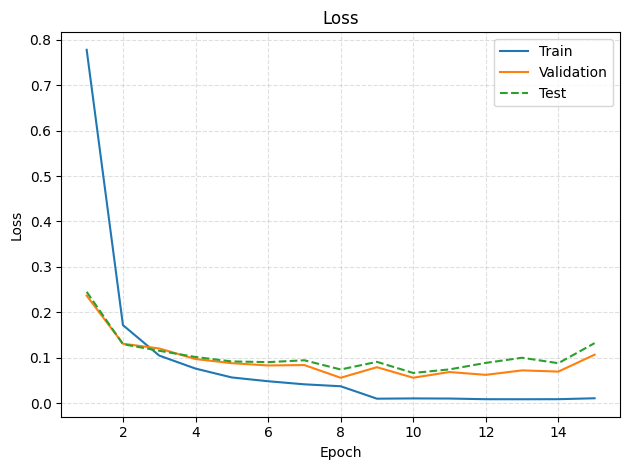

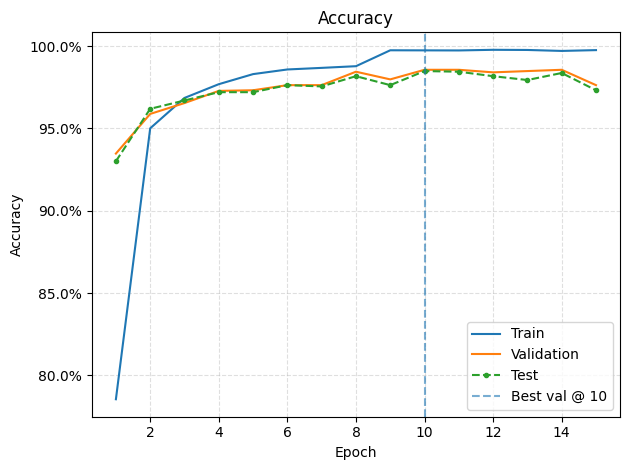

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path

RESULTS_DIR = Path("./results_tp8")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

epochs_tr = np.arange(1, len(train_losses) + 1)
epochs_va = np.arange(1, len(val_losses)   + 1)
epochs_te = np.arange(1, len(test_losses)  + 1)  # si tu logs test à chaque epoch

# ----- LOSS -----
plt.figure()
plt.plot(epochs_tr, train_losses, label="Train")
plt.plot(epochs_va, val_losses,   label="Validation")
if len(test_losses) > 0:
    plt.plot(epochs_te, test_losses,   label="Test", linestyle="--")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout()
plt.savefig(RESULTS_DIR / "curve_loss_with_test.png", dpi=150)
plt.show()

# ----- ACCURACY -----
plt.figure()
plt.plot(epochs_tr, train_accs, label="Train")
plt.plot(epochs_va, val_accs,   label="Validation")
if len(test_accs) > 0:
    plt.plot(epochs_te, test_accs,   label="Test", linestyle="--", marker="o", markersize=3)

# Marque la meilleure epoch validation
if len(val_accs) > 0:
    best_epoch = int(np.argmax(val_accs)) + 1
    plt.axvline(best_epoch, linestyle="--", alpha=0.6, label=f"Best val @ {best_epoch}")

plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout()
plt.savefig(RESULTS_DIR / "curve_accuracy_with_test.png", dpi=150)
plt.show()
